In [13]:
import seaborn as sns
import pandas as pd

from yome import Session
from yome.models import *
from yome.util import to_df, report, scale_color, mpl_setup
from yome.constants import colors, hatches_by_number

%mpl_setup

sns.set_style('ticks')

session = Session()

Populating the interactive namespace from numpy and matplotlib


# Find experiments with GEO accessions

In [14]:
metadata = pd.read_table('../data/precise/precise-og-metadata.csv', sep=',', index_col='sample_id')
tpm = pd.read_table('../data/precise/precise-og-tpm.csv.gz', sep=',', index_col=0, compression='gzip')
metadata.dropna(axis=0, subset=['GEO'], inplace=True)
tpm_filtered = tpm.loc[:, tpm.columns[tpm.columns.isin(metadata.index)]]
tpm_filtered.index.name = 'locus_tag'

In [15]:
metadata.loc[:, 'condition'] = list(metadata.index.str.replace('__\d', ''))

In [16]:
print(f'Samples before: {metadata.shape[0]}, samples after: {metadata.shape[0]}, data shape: {tpm_filtered.shape}')

Samples before: 122, samples after: 122, data shape: (3887, 122)


In [17]:
tpm_filtered.to_csv('../data/precise/tpm.tsv.gz', sep='\t', compression='gzip')
metadata[['condition', 'GEO']].to_csv('../data/precise/geo-accessions.tsv', sep='\t')

In [18]:
print(f'{len(metadata["condition"].drop_duplicates())} conditions')

78 conditions


In [19]:
# get mean
tpm_mean = pd.DataFrame({'mean_tpm': tpm.T.mean()})

In [20]:
# log2(x + 1)
tpm_log = tpm_filtered.applymap(lambda x: np.log2(x + 1))
tpm_log.to_csv('../data/precise/tpm-log.tsv', sep='\t')

# Import y-ome

In [21]:
y_ome_genes = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.annotation_quality)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'y-ome')
).rename(columns={'locus_id': 'locus_tag'})

In [22]:
# Merge the RNA-seq data with the y-ome
tpm_yome = pd.merge(tpm_mean.reset_index(), y_ome_genes, how='inner')

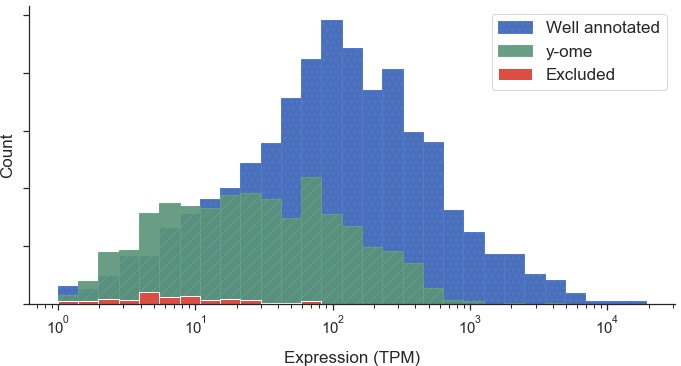

In [23]:
MAX = tpm_yome.mean_tpm.max()
bins = 10 ** np.linspace(0, np.log10(MAX), 30)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
high = tpm_yome[tpm_yome.annotation_quality == 'high'].mean_tpm
low = tpm_yome[tpm_yome.annotation_quality == 'low'].mean_tpm
excluded = tpm_yome[tpm_yome.annotation_quality == 'excluded'].mean_tpm
ax.set_xscale('log')
ax.hist(
    high,
    bins=bins,
#     histtype='step', 
    color=colors['blue'], 
    hatch=hatches_by_number[3],
    edgecolor=scale_color(colors['blue'], 1.1),
    label='Well annotated',
        #linewidth=3,  linestyle=':'
)
ax.hist(
    low,
    bins=bins,
    #histtype='step',
    color=colors['green'],
    edgecolor=scale_color(colors['green'], 1.1),
    hatch=hatches_by_number[2],
    label='y-ome', 
#         linewidth=3, linestyle='--'
    alpha=0.9,
)
ax.hist(
    excluded,
    bins=bins,
#     histtype='step',
    color=colors['red'],
#         linewidth=3,
    label = 'Excluded',
#     linestyle='-'
#     alpha=0.7,
)
ax.set_ylabel('Count')
ax.set_xlabel('Expression (TPM)', labelpad=15)
# hide top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticklabels([])
plt.legend(loc='upper right')
fig.set_facecolor('white')
fig.savefig('/Users/zaking/lab/y-ome/figs/expression.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/expression.png')

In [24]:
high.mean(), low.mean()

(351.22626562218375, 74.3374341901191)

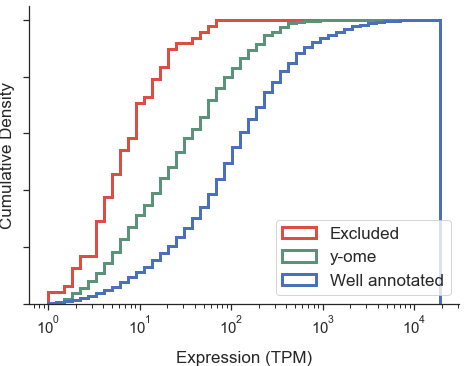

In [25]:
# cumulative density plot
MAX = tpm_yome.mean_tpm.max()
bins = 10 ** np.linspace(0, np.log10(MAX), 50)

fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
high = tpm_yome[tpm_yome.annotation_quality == 'high'].mean_tpm
low = tpm_yome[tpm_yome.annotation_quality == 'low'].mean_tpm
excluded = tpm_yome[tpm_yome.annotation_quality == 'excluded'].mean_tpm
ax.set_xscale('log')

# TODO smooth
# TODO line style in addition to color
# TODO proteomics
# TODO lines in legend & hide lines on right side of plots
# TODO What's the right y-axis label; check MEE paper

ax.hist(
    excluded,
    bins=bins,
    histtype='step',
    cumulative=True,
    density=True,
#     histtype='step',
    color=colors['red'],
#         linewidth=3,
    label = 'Excluded',
#     linestyle='-'
#     alpha=0.7,
    linewidth=3,
)
ax.hist(
    low,
    bins=bins,
    histtype='step',
    cumulative=True,
    density=True,
    #histtype='step',
    color=colors['green'],
#     edgecolor=scale_color(colors['green'], 1.1),
#     hatch=hatches_by_number[2],
    label='y-ome', 
    linewidth=3,
#     linestyle='--'
#     alpha=0.9,
)
ax.hist(
    high,
    bins=bins,
    histtype='step',
    cumulative=True,
    density=True,
    color=colors['blue'], 
#     hatch=hatches_by_number[3],
#     edgecolor=scale_color(colors['blue'], 1.1),
    label='Well annotated',
    linewidth=3,
)
ax.set_ylabel('Cumulative Density')
ax.set_xlabel('Expression (TPM)', labelpad=15)
# hide top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticklabels([])
plt.legend(loc='lower right')
fig.set_facecolor('white')
fig.savefig('/Users/zaking/lab/y-ome/figs/expression-cumulative.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/expression-cumulative.png')

## Proteomics

In [26]:
prot = pd.read_table('../data/nbt-schmidt/counts.tsv').rename(columns={'Gene': 'primary_name'})
prot.head()
# TODO join to locus_tags

,Unnamed: 0,Uniprot Accession,Description,primary_name,Peptides.used.for.quantitation,Confidence.score,Molecular weight (Da),Dataset,Glucose,LB,...,Stationary phase 1 day,Stationary phase 3 days,Osmotic-stress glucose,42°C glucose,pH6 glucose,Xylose,Mannose,Galactose,Succinate,Fructose
0,0,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=E...,rpoC,91,6045.53,155045.0080,2,2779,7164,...,1735,1907,2248,3985,3339,3632.0,3401.0,2258,2764,4517.0
1,1,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Es...,rpoB,89,5061.29,150520.2758,2,3957,8888,...,2379,2227,3254,4923,4032,4437.0,4143.0,2820,3855,5269.0
2,2,P36683,Aconitate hydratase 2 OS=Escherichia coli (str...,acnB,67,4505.67,93420.9457,2,7596,16600,...,933,756,2815,4842,4649,6697.0,16517.0,12875,19547,8782.0
3,3,P15254,Phosphoribosylformylglycinamidine synthase OS=...,purL,65,4277.71,141295.8984,2,2456,821,...,618,735,1318,1885,1708,1721.0,1764.0,1570,1913,2406.0
4,4,P09831,Glutamate synthase [NADPH] large chain OS=Esch...,gltB,64,4111.74,163176.3153,2,2859,604,...,230,183,834,2979,2723,2496.0,2079.0,1398,1553,3858.0


In [27]:
# get primary names
primary_names = to_df(
    session.query(
        Gene.locus_id,
        KnowledgebaseGene.primary_name,
    )
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(Knowledgebase, Knowledgebase.id == KnowledgebaseGene.knowledgebase_id)
    .filter(Knowledgebase.name == 'EcoCyc')
    
).rename(columns={'locus_id': 'locus_tag'})

In [28]:
primary_names.describe()
# NOTE: genes with two primary names for a locus tag do not appear in the 
#       proteomics dataset, so we can ignore them

,locus_tag,primary_name
count,4603,4603
unique,4603,4603
top,b4206,ydjX
freq,1,1


In [29]:
prot_yome = prot.merge(primary_names).merge(y_ome_genes)

In [30]:
prot_yome.head()

,Unnamed: 0,Uniprot Accession,Description,primary_name,Peptides.used.for.quantitation,Confidence.score,Molecular weight (Da),Dataset,Glucose,LB,...,Osmotic-stress glucose,42°C glucose,pH6 glucose,Xylose,Mannose,Galactose,Succinate,Fructose,locus_tag,annotation_quality
0,0,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=E...,rpoC,91,6045.53,155045.0080,2,2779,7164,...,2248,3985,3339,3632.0,3401.0,2258,2764,4517.0,b3988,high
1,1,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Es...,rpoB,89,5061.29,150520.2758,2,3957,8888,...,3254,4923,4032,4437.0,4143.0,2820,3855,5269.0,b3987,high
2,2,P36683,Aconitate hydratase 2 OS=Escherichia coli (str...,acnB,67,4505.67,93420.9457,2,7596,16600,...,2815,4842,4649,6697.0,16517.0,12875,19547,8782.0,b0118,high
3,3,P15254,Phosphoribosylformylglycinamidine synthase OS=...,purL,65,4277.71,141295.8984,2,2456,821,...,1318,1885,1708,1721.0,1764.0,1570,1913,2406.0,b2557,high
4,4,P09831,Glutamate synthase [NADPH] large chain OS=Esch...,gltB,64,4111.74,163176.3153,2,2859,604,...,834,2979,2723,2496.0,2079.0,1398,1553,3858.0,b3212,high


In [31]:
len(prot), len(prot_yome)

(2359, 2220)

In [32]:
prot_yome.columns

Index(['Unnamed: 0', 'Uniprot Accession', 'Description', 'primary_name',
       'Peptides.used.for.quantitation', 'Confidence.score',
       'Molecular weight (Da)', 'Dataset', 'Glucose', 'LB', 'Glycerol + AA',
       'Acetate', 'Fumarate', 'Glucosamine', 'Glycerol', 'Pyruvate',
       'Chemostat µ=0.5', 'Chemostat µ=0.35', 'Chemostat µ=0.20',
       'Chemostat µ=0.12', 'Stationary phase 1 day', 'Stationary phase 3 days',
       'Osmotic-stress glucose', '42°C glucose', 'pH6 glucose', 'Xylose',
       'Mannose', 'Galactose ', 'Succinate', 'Fructose', 'locus_tag',
       'annotation_quality'],
      dtype='object')

In [33]:
condition_columns = ['Glucose', 'LB', 'Glycerol + AA',
       'Acetate', 'Fumarate', 'Glucosamine', 'Glycerol', 'Pyruvate',
       'Chemostat µ=0.5', 'Chemostat µ=0.35', 'Chemostat µ=0.20',
       'Chemostat µ=0.12', 'Stationary phase 1 day', 'Stationary phase 3 days',
       'Osmotic-stress glucose', '42°C glucose', 'pH6 glucose', 'Xylose',
       'Mannose', 'Galactose ', 'Succinate', 'Fructose']

In [34]:
prot_yome.loc[:, 'mean_val'] = prot_yome.loc[:, condition_columns].mean(axis=1)

In [35]:
prot_yome.head()

,Unnamed: 0,Uniprot Accession,Description,primary_name,Peptides.used.for.quantitation,Confidence.score,Molecular weight (Da),Dataset,Glucose,LB,...,42°C glucose,pH6 glucose,Xylose,Mannose,Galactose,Succinate,Fructose,locus_tag,annotation_quality,mean_val
0,0,P0A8T7,DNA-directed RNA polymerase subunit beta' OS=E...,rpoC,91,6045.53,155045.0080,2,2779,7164,...,3985,3339,3632.0,3401.0,2258,2764,4517.0,b3988,high,3313.818182
1,1,P0A8V2,DNA-directed RNA polymerase subunit beta OS=Es...,rpoB,89,5061.29,150520.2758,2,3957,8888,...,4923,4032,4437.0,4143.0,2820,3855,5269.0,b3987,high,4075.136364
2,2,P36683,Aconitate hydratase 2 OS=Escherichia coli (str...,acnB,67,4505.67,93420.9457,2,7596,16600,...,4842,4649,6697.0,16517.0,12875,19547,8782.0,b0118,high,12254.500000
3,3,P15254,Phosphoribosylformylglycinamidine synthase OS=...,purL,65,4277.71,141295.8984,2,2456,821,...,1885,1708,1721.0,1764.0,1570,1913,2406.0,b2557,high,1736.363636
4,4,P09831,Glutamate synthase [NADPH] large chain OS=Esch...,gltB,64,4111.74,163176.3153,2,2859,604,...,2979,2723,2496.0,2079.0,1398,1553,3858.0,b3212,high,1745.181818


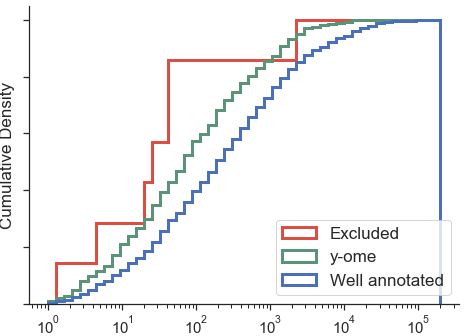

In [36]:
# cumulative density plot
MAX = prot_yome.mean_val.max()
bins = 10 ** np.linspace(0, np.log10(MAX), 50)

fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
high = prot_yome[prot_yome.annotation_quality == 'high'].mean_val
low = prot_yome[prot_yome.annotation_quality == 'low'].mean_val
excluded = prot_yome[prot_yome.annotation_quality == 'excluded'].mean_val
ax.set_xscale('log')

# TODO smooth
# TODO line style in addition to color
# TODO proteomics
# TODO lines in legend & hide lines on right side of plots
# TODO What's the right y-axis label?; check MEE paper
# TOOD What's the right x-axis label?

ax.hist(
    excluded,
    bins=bins,
    histtype='step',
    cumulative=True,
    density=True,
#     histtype='step',
    color=colors['red'],
#         linewidth=3,
    label = 'Excluded',
#     linestyle='-'
#     alpha=0.7,
    linewidth=3,
)
ax.hist(
    low,
    bins=bins,
    histtype='step',
    cumulative=True,
    density=True,
    #histtype='step',
    color=colors['green'],
#     edgecolor=scale_color(colors['green'], 1.1),
#     hatch=hatches_by_number[2],
    label='y-ome', 
    linewidth=3,
#     linestyle='--'
)
ax.hist(
    high,
    bins=bins,
    histtype='step',
    cumulative=True,
    density=True,
    color=colors['blue'], 
#     hatch=hatches_by_number[3],
#     edgecolor=scale_color(colors['blue'], 1.1),
    label='Well annotated',
    linewidth=3,
)
ax.set_ylabel('Cumulative Density')
ax.set_xlabel('', labelpad=15)
# hide top and right axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticklabels([])
plt.legend(loc='lower right')
fig.set_facecolor('white')
fig.savefig('/Users/zaking/lab/y-ome/figs/proteomics-cumulative.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/proteomics-cumulative.png')